# Pairs Trading Simulation

Aaron Lai<br/>

## Assignment Brief

**Problem Statement**

A trader has noticed a correlation between the instruments X and Y, and thinks we could make money by trading them when the prices diverge too much. Your job is to explore this opportunity and evaluate whether such a strategy could work.

**Objectives**

Dataset Exploration
- You have been provided data for 2 different financial instruments over a 1-year period, top level bid ask price and volume
- Explore the dataset and present the findings (e.g. anomalies, correlations, periodic patterns)

Pricing Relationships
- Identify potential pricing signals based on the relationships/patterns discovered in the previous step
- Develop and test whether these signals are a good predictor of future

Trading Strategy
- Based on your findings above, describe how you would monetise the opportunity
- Describe metrics you can use to measure performance of the strategy
- Plot the profit of your trading strategy over time
- Highlight limitations of the signals and strategy
- Provide potential areas for further research


## Preliminary Investigation

Prior to any in-depth analysis of data or trading algorithm implementations, some eye tests for the data will be done to determine a general idea of the higher level patterns. Specifically, visual scatterplot analysis of data as the brief implies that there may be some kind of correlation or relationship connecting the financial instruments X and Y together.

**Dataset Provided**
- DateTime (10 second snapshots, 6 snapshots/min)
- X_BID
- X_BID_VOL
- X_ASK
- X_ASK_VOL
- Y_BID
- Y_BID_VOL
- Y_ASK
- Y_ASK_VOL

Bid/Ask values are in $AUD, volumes are the count of the financial instruments X, Y at the min. ask/max. bid respectively.

In [3]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from scipy.stats import pearsonr
from scipy.stats import linregress
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

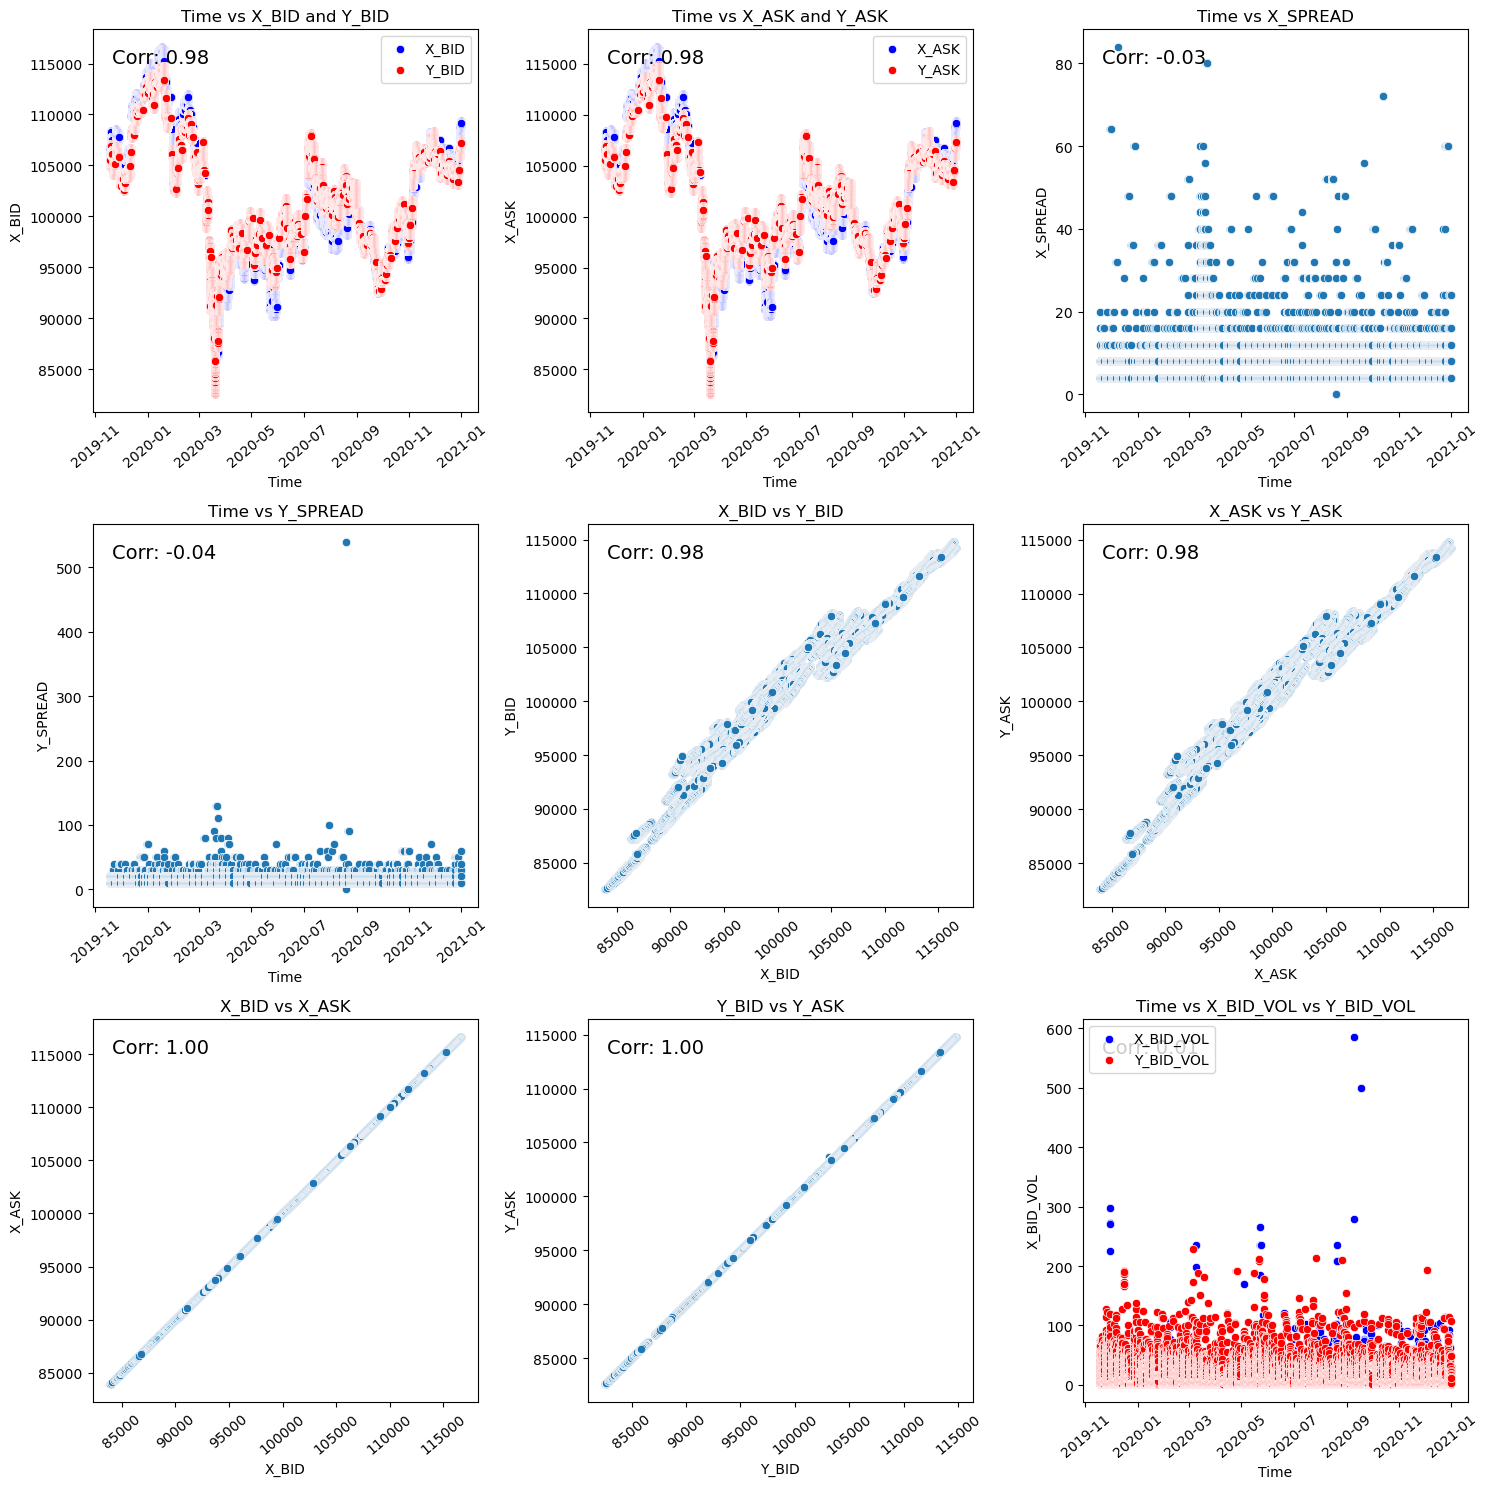

In [87]:
data = pd.read_csv('final_data_10s.csv', parse_dates=['Time'])
data['Date'] = data['Time'].dt.date

# Calculate the bid-ask spread for X and Y
data['X_SPREAD'] = data['X_ASK'] - data['X_BID']
data['Y_SPREAD'] = data['Y_ASK'] - data['Y_BID']

# Initialize a grid of plots with the size 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# List of plots to create
plots = [
    ('Time', 'X_BID', 'Y_BID', 'Time vs X_BID and Y_BID', 'X_BID', 'Y_BID'),
    ('Time', 'X_ASK', 'Y_ASK', 'Time vs X_ASK and Y_ASK', 'X_ASK', 'Y_ASK'),
    ('Time', 'X_SPREAD', '', 'Time vs X_SPREAD', 'X_SPREAD', ''),
    ('Time', 'Y_SPREAD', '', 'Time vs Y_SPREAD', 'Y_SPREAD', ''),
    ('X_BID', 'Y_BID', '', 'X_BID vs Y_BID', 'X_BID', 'Y_BID'),
    ('X_ASK', 'Y_ASK', '', 'X_ASK vs Y_ASK', 'X_ASK', 'Y_ASK'),
    ('X_BID', 'X_ASK', '', 'X_BID vs X_ASK', 'X_BID', 'X_ASK'),
    ('Y_BID', 'Y_ASK', '', 'Y_BID vs Y_ASK', 'Y_BID', 'Y_ASK'),
    ('Time', 'X_BID_VOL', 'Y_BID_VOL', 'Time vs X_BID_VOL vs Y_BID_VOL', 'X_BID_VOL', 'Y_BID_VOL')
]

# Plot each subplot
for ax, (x, y1, y2, title, label1, label2) in zip(axes.flatten(), plots):
    if y2:
        sns.scatterplot(data=data, x=x, y=y1, ax=ax, label=label1, color='b')
        sns.scatterplot(data=data, x=x, y=y2, ax=ax, label=label2, color='r')
        corr = data[[y1, y2]].corr().iloc[0, 1]
        ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.legend()
    else:
        sns.scatterplot(data=data, x=x, y=y1, ax=ax)
        corr = data[[x, y1]].corr().iloc[0, 1]
        ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
    
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=40)
        

# Adjust layout
plt.tight_layout()
plt.show()

**Preliminary Analysis**

Some early observations on the data:
- reasonable to test for correlation (coefficients) and cointegration between the two instruments X and Y.
- movement of instruments X and Y may be cyclic annually, but unsure (no external context provided)
- one anomalous point in the bid-ask spread of Y, but other than that, bid-ask-spread of both instruments is relatively constant
- two possible outliers in the X_BID_VOL but should not be of any particular concern for a trading algorithm

## Main Investigation

Given the above observations and the first trader seeing an opportunity to "make money by trading them when the prices diverge too much", I plan to explore the cointegration of X and Y and thereby try and develop an effective mean reversion pairs trading strategy.

**Approach**

1. Conduct hypothesis testing to determine whether X and Y fulfill cointegration conditions
2. Calculate the movement of the spread Y-X around a mean
3. Determine entry/exit signals
4. Formulate a trading strategy
5. Test trading strategy on a test set
6. Experiment with hyperparameters

### Testing for Cointegration

Test 1: Stationarity Check - Ensure that the movement of the securities are independently non-stationary (will be using ADF)<br/>
Test 2: Cointegration Test - Test for cointegration between X and Y (meaning their price ratio is stationary/mean reverting long term)

In [88]:
# Function to perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    p_value = result[1]
    
    alpha = 0.05  # 5% significance level
    if p_value < alpha:
        print(f"{series.name} is stationary (p-value: {p_value:.4f})")
    else:
        print(f"{series.name} is non-stationary (p-value: {p_value:.4f})")

# Function to perform cointegration test
def cointegration_test(series1, series2):
    _, p_value, _ = coint(series1, series2)
    alpha = 0.05  # 5% significance level
    if p_value < alpha:
        print(f"The series are cointegrated (p-value: {p_value:.4f})")
    else:
        print(f"The series are not cointegrated (p-value: {p_value:.4f})")

In [89]:
# Change index to DateTime for resampling
data.set_index('Time', inplace=True)

# Resample data to daily since the current dataset is too large for processing 10 snapshots a minute
resample_freq = '1D' 

# From the graphs above, the bid and ask values have a near perfect correlation, so tests for cointegration will just be using bid values
X_BID_Sample = data['X_BID'].resample(resample_freq).last()
Y_BID_Sample = data['Y_BID'].resample(resample_freq).last()

# Test stationarity of individual securities
print("ADF Test for resampled X_BID:")
adf_test(X_BID_Sample)
print("\nADF Test for resampled Y_BID:")
adf_test(Y_BID_Sample)

# Test cointegration between the two securities
print("\nCointegration Test for resampled X_BID, resampled Y_BID:")
cointegration_test(X_BID_Sample, Y_BID_Sample)

ADF Test for resampled X_BID:
X_BID is non-stationary (p-value: 0.3582)

ADF Test for resampled Y_BID:
Y_BID is non-stationary (p-value: 0.1884)

Cointegration Test for resampled X_BID, resampled Y_BID:
The series are not cointegrated (p-value: 0.0792)


**Results of Cointegration Tests**

For faster of calculation, the bid values were **resampled down to 1 value each day**, and then the cointegration was tested. Although the ADF tests were successful (both securities were found to be non-stationary), the cointegration test **failed**. I hypothesise that this is likely due to the **extremely frequent/high number** of snapshots (10 snapshots per minute), which captures noise and very short term movement that may not be cointegrated. 

Subsequent ADF and cointegration tests will be done on **aggregated daily averages (mean)** of the X_BID and Y_BID values to see whether there is cointegration at a higher level time scale.

In [90]:
# Reset index
data = data.reset_index()

# Group by day and calculate the daily mean
daily_X_mean = data.groupby(data['Time'].dt.date)['X_BID'].mean()
daily_Y_mean = data.groupby(data['Time'].dt.date)['Y_BID'].mean()

# Test stationarity of daily mean of individual securities
print("ADF Test for daily X_BID mean:")
adf_test(daily_X_mean)
print("\nADF Test for daily Y_BID mean:")
adf_test(daily_Y_mean)

# Test cointegration between the two securities (daily means)
print("\nCointegration Test for daily X/Y Bid means")
cointegration_test(daily_X_mean, daily_Y_mean)

ADF Test for daily X_BID mean:
X_BID is non-stationary (p-value: 0.4423)

ADF Test for daily Y_BID mean:
Y_BID is non-stationary (p-value: 0.2482)

Cointegration Test for daily X/Y Bid means
The series are not cointegrated (p-value: 0.0579)


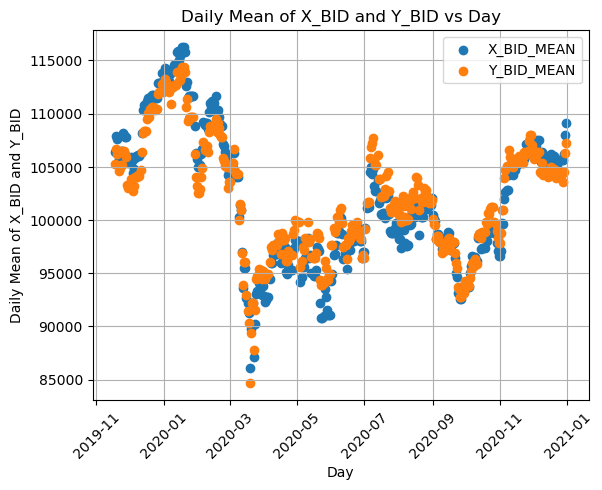

In [91]:
# Plot the daily means (X_BID, Y_BID vs Day) on a scatter plot
plt.scatter(daily_X_mean.index, daily_X_mean.values, label='X_BID_MEAN')
plt.scatter(daily_Y_mean.index, daily_Y_mean.values, label='Y_BID_MEAN')
plt.xlabel('Day')
plt.legend()
plt.ylabel('Daily Mean of X_BID and Y_BID')
plt.title('Daily Mean of X_BID and Y_BID vs Day')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Results of Cointegration Tests (Part 2)**

The p-value for the daily mean values was 0.0579, which was lower than the randomly resampled values (p-value = 0.0792). Although we have not achieved the 95% confidence level that is desired for a standard hypothesis test, it is very close to the 0.05 threshold. Therefore, a reasonable assumption of cointegration between X and Y will be made. 

It should be noted that these results are not ideal, and further exploration of the data is necessary, however, given a lack of background understanding of the securities and the limited dataset, these findings will be deemed sufficient for now as a mean reversion trading algorithm is developed.

### Price Ratio vs Mean

Given that X and Y are cointegrated, the next step is to observe the movement of the price ratio around the mean, looking for mean reverting behaviour. This will then be normalised using z-scores so that suitable signals can be determined given certain z-score thresholds.

**Brief summary of (my understanding of) mean reversion pairs trading strategy**

Given a pair of cointegrated assets, it is assumed that they are likely to revert back to the mean (in the long term) after deviating. Hence, traders can exploit this behaviour by longing the underperforming asset and shorting the overperforming asset, and exiting once the mean is reached again, closing the trading position at a gain. There is the assumption that both assets will continue to be cointegrated in the future, but practically, this may not be the case

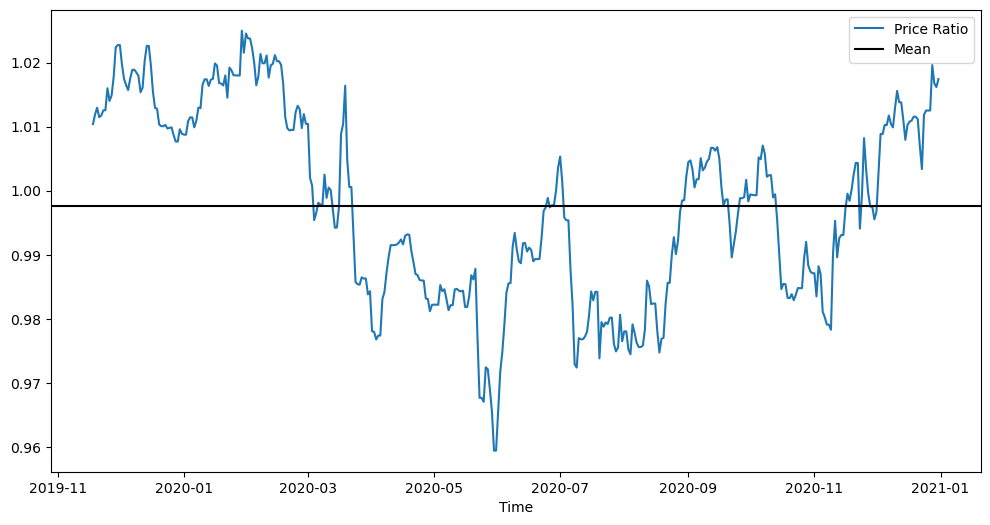

In [92]:
ratio = daily_X_mean / daily_Y_mean
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio', 'Mean']);
plt.show()

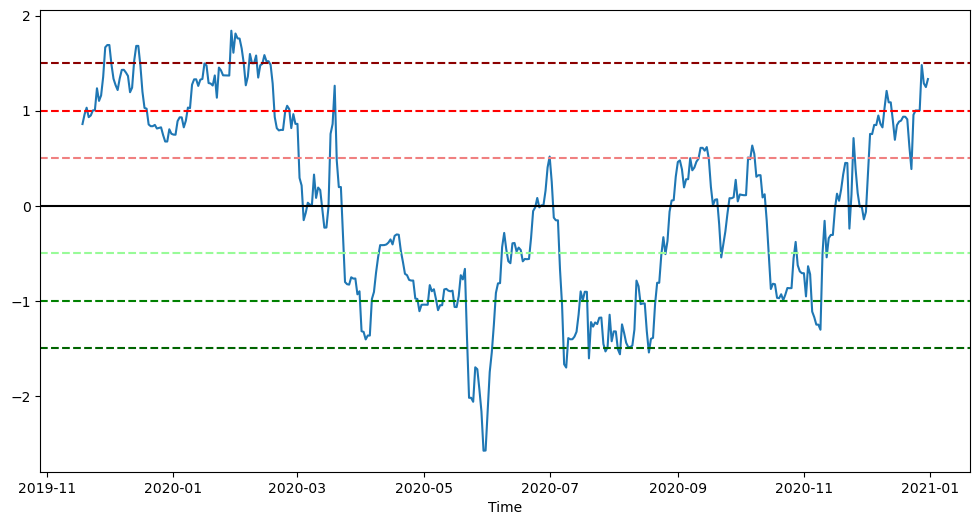

In [93]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean(), color='black')
plt.axhline(0.5, color='lightcoral', linestyle='--')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(1.5, color='darkred', linestyle='--')
plt.axhline(-0.5, color='palegreen', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.axhline(-1.5, color='darkgreen', linestyle='--')
plt.show()

**Price Ratio & Z-score analysis**

I just noted a few critical z-score thresholds (0.5, 1.0, 1.5) in both directions about the mean. Generally, the threshold in mean reversion pairs trading is a one standard deviation away, but some tuning of the hyperparameters may improve trading algorithm profitability.

Overall, movement is as expected, generally coming back to the mean after the price ratio moves beyond one standard deviation away from the mean. 

### Determine entry & exit signals

To avoid **overfitting and lookahead bias**, I will be using a 70/30 train-test split, and using moving averages to determine mean of the price ratio at any given instance.

In [94]:
ratios = daily_X_mean / daily_Y_mean
split_index = round(len(ratios) * .70)   # for daily means dataset
split_index_ss = round(len(data) * .70)  # for entire dataset

train = ratios[:split_index]
test = ratios[split_index:]

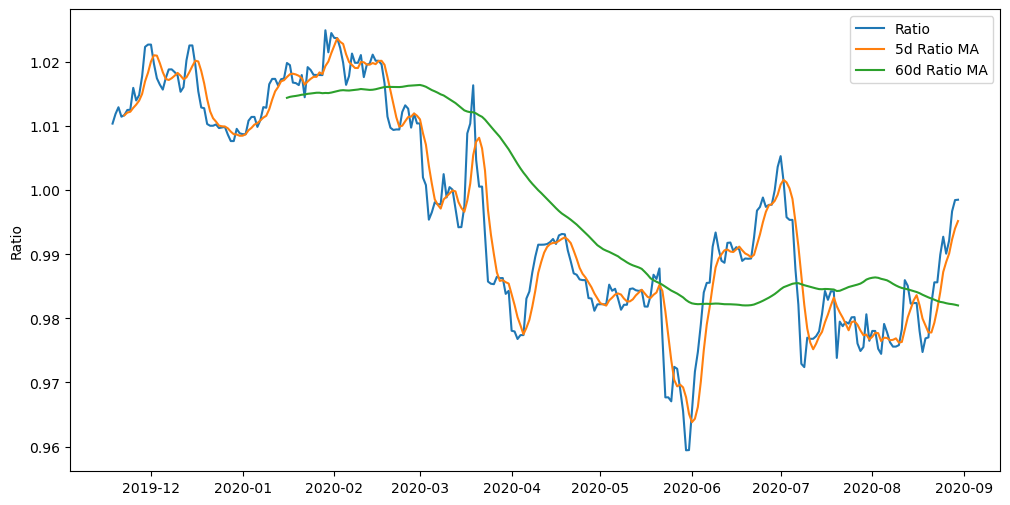

In [95]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

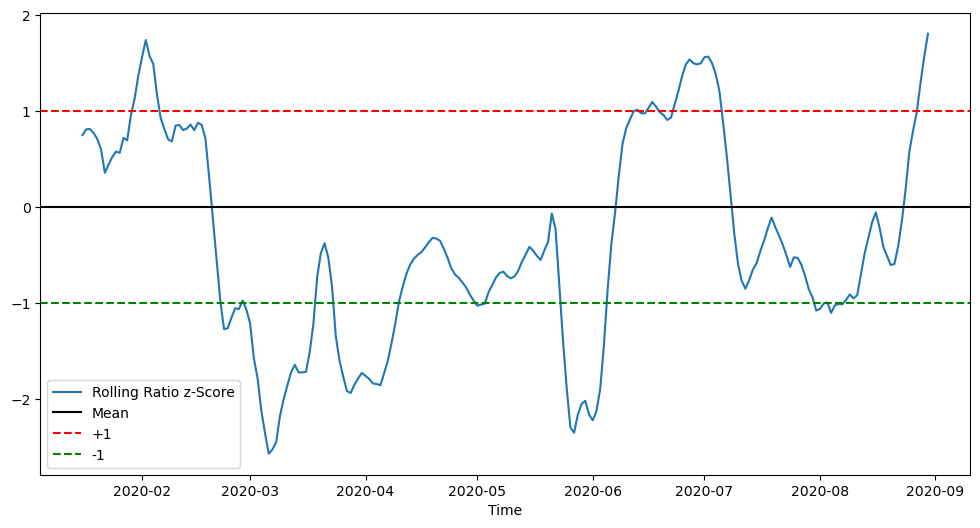

In [96]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

**Buy/Sell Signals**

Now that we are using the moving averages to determine whether to buy or sell the ratio, we can then plot the buy and sell signals (when z-score is beyond 1 standard deviation) to visually see at what points should a trading algorithm buy or sell the ratio.

**Note:**
<br/>HIGH z-score (signal -1) --> X is unusually expensive, Y is unusually cheap --> expect ratio to go back DOWN (mean reverting) --> should SHORT the ratio
<br/>Shorting the ratio = short X (sell high) and long Y (buy low)
<br/>
<br/>LOW z-score (signal 1) --> X is unusually cheap, Y is unusually expensive --> expect ratio to go back UP (mean reverting) --> should LONG the ratio
<br/>Longing the ratio = long X (buy low) and short Y (sell high)

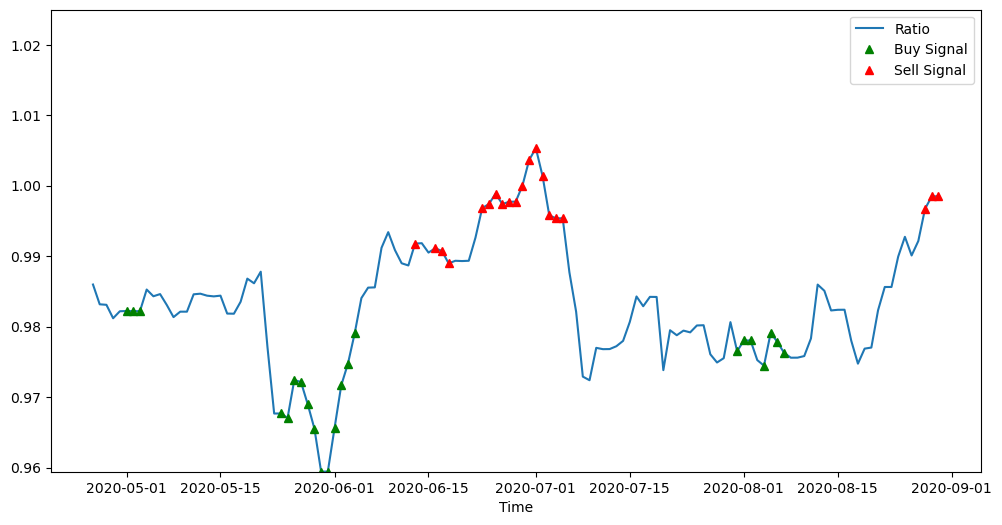

In [97]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

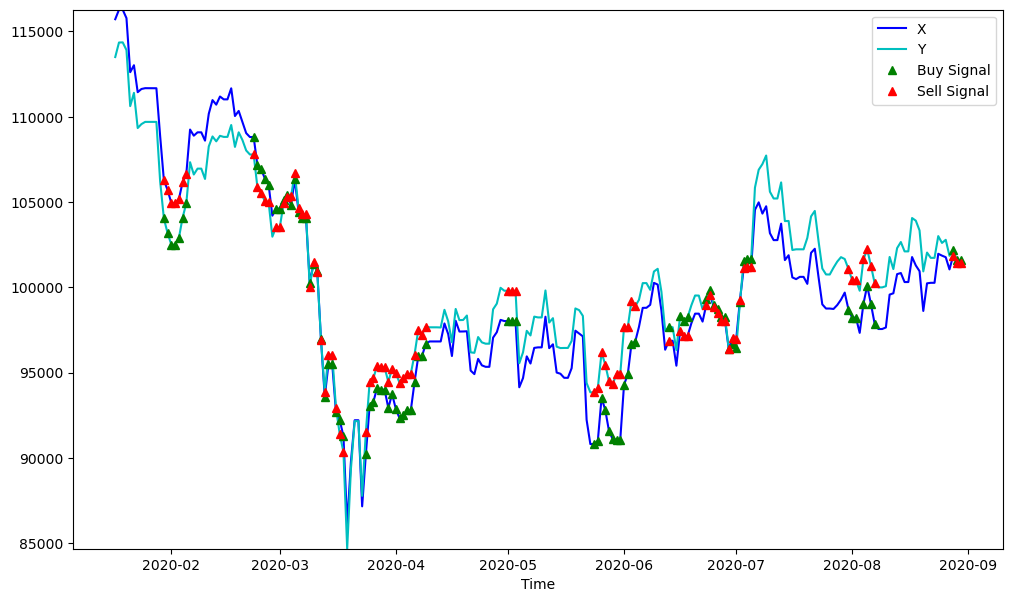

In [98]:
plt.figure(figsize=(12,7))
S1 = daily_X_mean.iloc[:split_index]
S2 = daily_Y_mean.iloc[:split_index]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

plt.legend(['X', 'Y', 'Buy Signal', 'Sell Signal'])
plt.show()

**Optimising transactions with bid-ask spread**

Considering that the dataset provided gives bid-ask values, with such high frequency instances, there is the opportunity to make a minor optimisation to the trading strategy's efficiency/relative return by only trading when the bid-ask spread is low, since buying and selling will need to cover the cost of the transaction (=bid-ask spread).

Observing the basic boxplot stats, I decided to create an additional trading condition, which is that the X and Y bid-ask spread must be less than or equal to the 1st Quarter of the bid-ask spread distribution. 

Minimum (or smaller quantiles) were not used, as such a limitation could significantly limit the volume of trades made with plateauing returns on the average % return per trade.

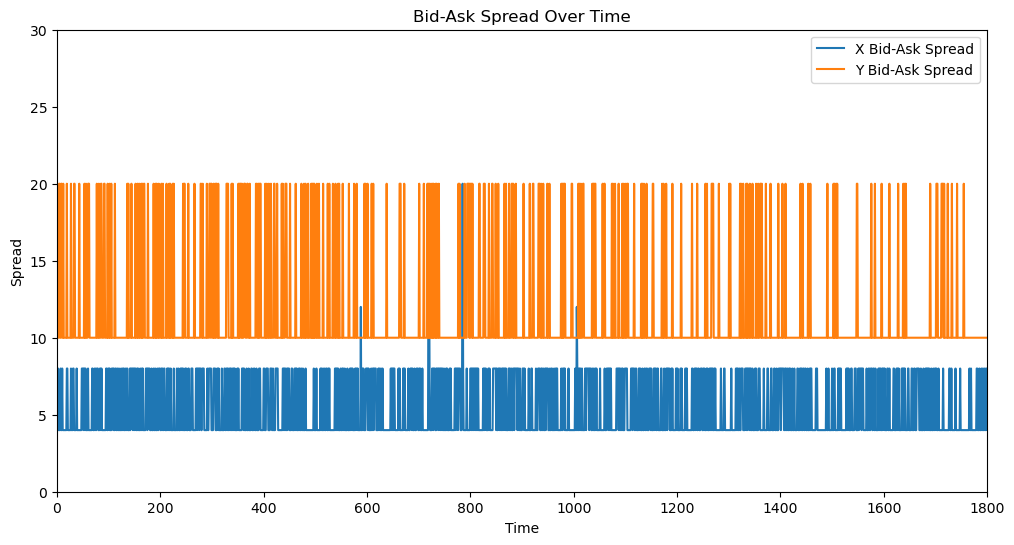

X Mean of Bid-Ask Spread: 14.3
X Median of Bid-Ask Spread: 8.0
X Standard Deviation of Bid-Ask Spread: 14.4
Y Mean of Bid-Ask Spread: 20.3
Y Median of Bid-Ask Spread: 20.0
Y Standard Deviation of Bid-Ask Spread: 16.0
Q1 X 8.0
Q1 Y 10.0


In [99]:
# Plot the bid-ask spread
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['X_SPREAD'], label='X Bid-Ask Spread')
plt.plot(data.index, data['Y_SPREAD'], label='Y Bid-Ask Spread')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.title('Bid-Ask Spread Over Time')
plt.ylim(0, 30)
plt.xlim(0, 1800)    # see a snapshot of 1 day, given preliminary tests, bid-ask spread is generally consistent
plt.legend()
plt.show()

# Calculate the mean and standard deviation of the bid-ask spread
X_spread_mean = data['X_SPREAD'].mean()
X_spread_median = data['X_SPREAD'].median()
X_spread_std = data['X_SPREAD'].std()
Y_spread_mean = data['Y_SPREAD'].mean()
Y_spread_median = data['Y_SPREAD'].median()
Y_spread_std = data['Y_SPREAD'].std()

print(f'X Mean of Bid-Ask Spread: {X_spread_mean:.1f}')
print(f'X Median of Bid-Ask Spread: {X_spread_median}')
print(f'X Standard Deviation of Bid-Ask Spread: {X_spread_std:.1f}')

print(f'Y Mean of Bid-Ask Spread: {Y_spread_mean:.1f}')
print(f'Y Median of Bid-Ask Spread: {Y_spread_median}')
print(f'Y Standard Deviation of Bid-Ask Spread: {Y_spread_std:.1f}')

print(f'Q1 X {data['X_SPREAD'].quantile(0.25):.1f}')
X_BAS_threshold = data['X_SPREAD'].quantile(0.25)

print(f'Q1 Y {data['Y_SPREAD'].quantile(0.25):.1f}')
Y_BAS_threshold = data['Y_SPREAD'].quantile(0.25)

### Formulate Trading Strategy

With the theory and signal identification strategy in place, a mean reversion pairs trading algorithm can now be developed and tested on the test set. Default hyperparameters will be set for all the functions, but further tuning of the hyperparameters could lead to some improvements in the algorithm.

**Evaluating Success of Trading Strategy**

1. Absolute profit/loss: An $AUD profit/loss will be produced, but this is rather insignificant since there is no specific budget, and therefore the algorithm will operate under the assumption that there is an indefinite budget
2. Average Percentage Return Per Trade: Finding the average % return per trade is a better means of evaluating the efficiency of each trade, and rewards safer trading (since there is a greater buffer for fluctuations)
3. CAGR: The average % return per trade is only relevant for the 3-4 month test set window, hence the results need to be extrapolated to find an approximate 
compound annual growth rate (CAGR) that can be compared to other investment strategies (ie. index funds/ETFs)

In [110]:
def bid_ask_condition(dataset, index):
    if (dataset.loc[index, 'X_SPREAD'] <= X_BAS_threshold and dataset.loc[index, 'Y_SPREAD'] <= Y_BAS_threshold):
        return True
    
    return False

def calculate_ratio(dataset, ticker1, ticker2):
    S1_daily_mean = dataset.groupby(data['Time'].dt.date)[f'{ticker1}_BID'].mean()
    S2_daily_mean = dataset.groupby(data['Time'].dt.date)[f'{ticker2}_BID'].mean()
    
    return S1_daily_mean / S2_daily_mean

def identify_deviations(ratio, window1=5, window2=60):
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    z_score = (ma1 - ma2)/std
    
    return z_score

def generate_signals(z_score, z_open_threshold=2, z_close_threshold=0.5):
    signals = pd.Series(0, index=z_score.index)
    signals[z_score > z_open_threshold] = -1  # Short signal
    signals[z_score < -z_open_threshold] = 1  # Long signal
    signals[abs(z_score) < z_close_threshold] = 3  # Close/Exit Signal
    
    return signals

def average_return_per_trade(trade_record):
    sum_trades, avg_return = 0, 0

    # Find the total number of trades
    for i in range(len(trade_record)):
        sum_trades += trade_record[i][0]

    # Compute weighted sum of % return (given number of trades at that return)
    for i in range(len(trade_record)):
        avg_return += trade_record[i][1] * trade_record[i][0] / sum_trades

    return avg_return

def trade(dataset, signals, ticker1, ticker2):
    position = 0
    shares1, shares2, num_trades = 0, 0, 0
    invested_finance = 0
    total_profit_loss = 0
    trade_record = []  # append tuples of (num_trades, % return)
    
    for date, signal in signals.items():
        if date not in dataset['Date'].values:
            continue

        key_row = dataset.loc[dataset['Date'] == date]
        key_row = key_row.reset_index(drop=True)
        
        # Close existing position
        if signal == 3 and shares1 != 0:
            #print("CLOSE POSITION ----------")
            percentage_return = 0
            
            if position == 1:
                # Was a long signal, so expect S1 to have grown and S2 to have decreased, then SELL S1 (after long) and BUY BACK S2 (after short)
                # BUY at ASK price, SELL at BID price
                cash_from_sale1 = shares1 * key_row[f'{ticker1}_ASK'].tolist()[0]
                cash_to_buy2 = shares2 * key_row[f'{ticker2}_BID'].tolist()[0]
                delta = abs(cash_from_sale1) - abs(cash_to_buy2)
                
                percentage_return = delta / invested_finance * 100
                total_profit_loss += delta
                
                #print(f'Cash = +{cash_from_sale1}   {cash_to_buy2}  totalPL: {total_profit_loss}')
                #print(f'% PROF: {percentage_return}')
            if position == -1:
                # was a short signal, so we expect S1 to have fallen and S2 to grow, so we BUY S1 (after short) and SELL S2 (after long)
                # BUY at ASK price, SELL at BID
                cash_from_sale2 = shares2 * key_row[f'{ticker2}_ASK'].tolist()[0]
                cash_to_buy1 = shares1 * key_row[f'{ticker1}_BID'].tolist()[0]
                delta = abs(cash_from_sale2) - abs(cash_to_buy1)
                
                percentage_return = delta / invested_finance * 100
                total_profit_loss += delta
                
                #print(f'Cash = +{cash_from_sale2}   {cash_to_buy1}   totalPL: {total_profit_loss}')
                #print(f'% PROF: {percentage_return}')

            trade_record.append((num_trades, percentage_return))
            shares1, shares2, num_trades, invested_finance = 0, 0, 0, 0
        
        # Open new position
        if signal != 0 and signal != 3:
            position = signal
            
        if signal != 0:
            num_ss_in_day = len(key_row)
            
            for i in range(num_ss_in_day):
                if signal == 1 and bid_ask_condition(key_row, i):   # Long signal --> Long S1, Short S2 
                    
                    s1 = min(key_row[f'{ticker1}_ASK_VOL'].tolist()[i], 
                                  key_row[f'{ticker2}_BID_VOL'].tolist()[i] * key_row[f'{ticker2}_BID'].tolist()[i] / key_row[f'{ticker1}_ASK'].tolist()[i])
                    s2 = -s1 * key_row[f'{ticker1}_ASK'].tolist()[i] / key_row[f'{ticker2}_BID'].tolist()[i]

                    shares1 += s1
                    shares2 += s2

                    num_trades += 1
                    invested_finance += s1 * key_row[f'{ticker1}_ASK'].tolist()[i]
                
                if signal == -1 and bid_ask_condition(key_row, i):  # Short signal --> Short S1, Long S2
    
                    s2 = min(key_row[f'{ticker2}_ASK_VOL'].tolist()[i], key_row[f'{ticker1}_BID_VOL'].tolist()[i] * key_row[f'{ticker1}_BID'].tolist()[i] / key_row[f'{ticker2}_ASK'].tolist()[i])
                    s1 = -s2 * key_row[f'{ticker2}_ASK'].tolist()[i] / key_row[f'{ticker1}_BID'].tolist()[i]
                    
                    shares2 += s2
                    shares1 += s1

                    num_trades += 1
                    invested_finance += s2 * key_row[f'{ticker2}_ASK'].tolist()[i]
                

    print(f'Total Profit/Loss: {total_profit_loss:.2f}')
    print(f'Average Percentage Return Per Trade: {average_return_per_trade(trade_record):.2f}%')


In [111]:
test = data.iloc[split_index_ss:]
test = test.reset_index(drop=True)

ticker1 = 'X'
ticker2 = 'Y'

ratio = calculate_ratio(test, ticker1, ticker2)
z_score = identify_deviations(ratio)
signals = generate_signals(z_score)
trade(test, signals, ticker1, ticker2)

days_span = (test['Date'].max() - test['Date'].min()).days
print(f'Timespan: {days_span} days')

Total Profit/Loss: 42505421.84
Average Percentage Return Per Trade: 1.18%
Timespan: 123 days
